# ВВЕДЕНИЕ В МАШИННОЕ ОБУЧЕНИЕ

## Описание проекта

Оператор мобильной связи «Мегалайн» хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новые тарифы: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Необходимо постройте модель с максимально большим значением accuracy. Нужно довести долю правильных ответов по крайней мере до 0.75.



**План работы**
 * Открыть файл с данными и изучить его. Путь к файлу: datasets/users_behavior.csv. Скачать датасет.
 * Разделить исходные данные на обучающую, валидационную и тестовую выборки.
 * Исследовать качество разных моделей, меняя гиперпараметры. Кратко написать выводы исследования.
 * Проверить качество модели на тестовой выборке.
 * Дополнительное задание: проверить модель на вменяемость.

## Работа над проектом

Подключение библиотек.

In [ ]:
#подключение библиотек
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Открытие файла

In [ ]:
#датафрейм сохраняем в переменную
try:
  df = pd.read_csv("/datasets/users_behavior.csv")
except:
  df = pd.read_csv("users_behavior.csv")

Просмотр датафрейма.

In [ ]:
#вывод первых 5 строк датафрейма
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
#типы данных в признаках
df.dtypes

calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object

#### Вывод

Из датафрейма видно что целевой признак относится к задаче классификации, соответственно модели будут подбираться соответствующие. В таблице 4  простых признака и 1 целевой признак. В каждом признаке содержится количественные данные.

### Построение прогноза

Для построения обучающих моделей необходимо разделить датафрейм на признаки и целевой признак. 
Но перед этим обратим внимание на мультиколлерантность признаков.  
Для этого построим тепловую карту корреляции для датафрейма чтобы определить зависимые признаки.
Сразу определим допустимую корреляцию в 0.6.

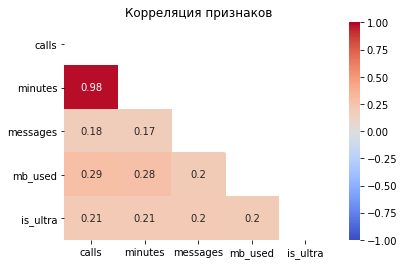

In [ ]:
#выделим значения для сокрытия их в тепловой карте
upp_mat = np.triu(df.corr())
#построение тепловой карты корреляции признаков
sns.heatmap(df.corr(),vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
plt.title("Корреляция признаков")
plt.show()

Из тепловой карты видно что минуты и звонки превышают значимое значение зависимости.

Построим диаграмму рассеяния для няглядности.

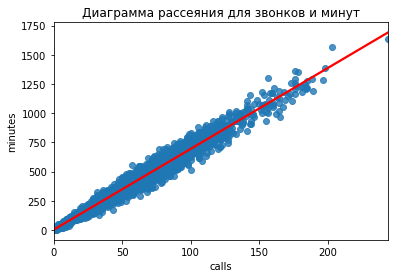

In [ ]:
#диаграмма рассеяния
sns.regplot(data = df, x = "calls", 
            y = "minutes", 
            ci = None,
            line_kws={"color": "red"})
plt.title("Диаграмма рассеяния для звонков и минут")
plt.show()

На диаграмме видна явная положительная зависимость, это говорит мультиколлинеарности.  
Для того чтобы исключить мультиколлинеарность удалим один из признаков и построим модель без него.

In [ ]:
#сохранение признаков
features = df.drop(["is_ultra","calls"], axis = 1)
target = df["is_ultra"]

Для обучения моделей разделим поделим признаки на 3 части. 

* Тренировочную - для обучения модели
* Валидационную - для проверки подели
* Тестовую - для оценки готовой модели

Т.к. мы пользуемся одним набором данных, то поделим признаки сначало в соотношении 80/20/20

In [ ]:
#деление на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            random_state = 12345,
                                                                            test_size = 0.4)

Поделим тестовую выборку пополам.

In [ ]:
#деление не тестовую и валидационную выборки
features_test, features_valid, target_test, target_valid = train_test_split(features_test, 
                                                                            target_test,
                                                                            random_state = 12345,
                                                                            test_size = 0.5)

Проверим соотношение объектов в каждой из выборок.

In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(1928, 3)
(643, 3)
(643, 3)


Выборки разделились хорошо.

Подберем наилучшую модель для более точного прогноза.
Чтобы оценить качество модели для задач классификации будет пользоваться  метрикой accuracy_score.


Дерево решений.
Зададим гиперпараметры. Для псевдослучайности random_state зададим 12345. Глубину дерева max_depth подберем в цикле для того чтобы избежать недообучения и переобучения. Выведем наилучшую точность и гиперпараметр.

In [ ]:
#нахождение наилучших параметров для дерева решений
best_tree_depht = 0
best_accuracy = 0


for depth in range(1,11):
        model = DecisionTreeClassifier(random_state = 12345,max_depth = depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy 
            best_tree_depth = depth
            best_model = model


print(best_accuracy)
print(best_tree_depth)



0.7962674961119751
7


Случайный лес.
Зададим гиперпараметры. Для псевдослучайности random_state зададим 12345. Глубину дерева max_depth подберем в цикле от 1 до 10. Количество деревьев подберем в цикле с шагом 10. Выведем наилучшую точность и гиперпараметры.

In [ ]:
#нахождение наилучших параметров для случайного леса
best_forest_depht = 0
best_nest = 0
best_accuracy = 0


for est in range(10, 51, 5):
    for depth in range(1,11):
        model = RandomForestClassifier(random_state = 12345,n_estimators = est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid,predictions)
        if accuracy>best_accuracy:
            best_accuracy =accuracy
            best_forest_depth = depth
            best_nest = est


print(best_accuracy)
print(best_forest_depth)
print(best_nest)


0.8087091757387247
8
10


Логистическая регрессия.

Выведем точность модели.

In [ ]:
# подсчет точноси для логистической регрессии
model = LogisticRegression(random_state = 12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid,predictions)
        
print(accuracy)



0.6982892690513219


#### Выводы

Как видим,  модель "Случайный лес" показала наибольшую точность в 80%. Количество деревьев 10 и глубина 8, такие гиперараметры дали наилучший результат. Логистическая регрессия показала худший результат.

Оценим готовую модель случайного леса на тестовой выборке.

In [ ]:
model = RandomForestClassifier(random_state = 12345, n_estimators = 10, max_depth = 9)
model.fit(features_train,target_train)
predictions = model.predict(features_test)

print(accuracy_score(target_test,predictions))

0.7869362363919129


Из результатов видно что доля правильных ответов при сравнении выборок составляет 78%. Это почти 8 из 10 правильных ответов.
